# Simulating an *ARMA(2)* process and making forecasts

The purpose of this notebook is creating a Auto-Regressive Moving Averagre (ARMA) process and analyzing it to make forecasts. First, let's view what a ARMA process is.

## Defining a Auto-Regressie Moving Averagae process

> **Auto-Regressie Moving Averagae process**: 
> In time series, an ARMA process is a combination of the Auto-Regressive process and the Moving Average process. Remembering that: 
  - > An **$AR(q)$** model is a linear combination of a constant $C$, the present error term $\epsilon_t$ which is also white noise, and the past values of the series $y_{t-p}$. The magnitude of the influence of the past values on the present value is denoted as $\phi_p$, which represents the coefficients of the $AR(p) $ model, where $p$ is the order. The general expression of an $AR(p)$ model is: Matehmatically, this is:
$$y_t = C + \epsilon_t + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p}$$
  - > An **$MA(q)$** model is a linear combination of the mean of series ($\mu$), the present error term ($\epsilon_t$), and past error terms ($\epsilon_{t-q}$). The magnitude of the impact of past errors on the present value is quantified using a coefficient denoted as $\theta_q$. Matehmatically, this is: $$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$   The order $q$ of the MA model determines the number of past error terms that affect the present value.
  
> Therefore, in an ***ARMA(p,q)*** process, $p$ is the order of the autoregressive  process, and $q$ is the order of the moving average process. The general equation of the ARMA(p,q) model is:
$$y_t = C + \phi_1 y_{t-1}+ \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \mu +  \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$

### General process to identify an $ARMA(p,q)$ model
The next diagram shows the steps to identify an $ARMA(p,q)$ model.

![ARMA process](img.PNG)

------------------------

## Actions to execute
In this notebook, we will simulate a ARMA(2,2) process using the equation:
$$y_t = 0.33 y_{t-1} + 0.50 y_{t-2} + 0.90 \epsilon_{t-1} + 0.30\epsilon_{t-2}$$
The actions to execute are:
1. Gather data: Simulate the $ARMA(2,2)$ model with the above equation.
2. Test stationary (*Augmented Dickey-Fuller  test*).
    - Apply transformations until our series is stationary (Differences).
3. Generate a list of $(p,q)$ candidates to approximate our model.
4. Get the best candidate, ie, fit every combination of $(p,q)$ and get the Akaike Information Criterion (*AIC*) for each model.
5. Select the model with the lowest *AIC* and apply a residual analysys (quantitative and cualitative).
    - If the model does not pass the residual analysis, the model choosen was not correct and it is necessary to select another $(p,q)$ combination.
5. Apply a method to forecast for the winner model.

## Part 1. Gather data

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import adfuller 
from tqdm import tqdm 
from typing import Union 

from itertools import product 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(777)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# simulating process
ar2 = np.array([1, -0.33, -0.50])
ma2 = np.array([1, 0.90, 0.30])


ARMA22_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

# data split: 80% for training and 20% for test
len_data = len(ARMA22_process)
train = ARMA22_process[:int(0.8*len_data)]
test = ARMA22_process[int(0.8*len_data):]

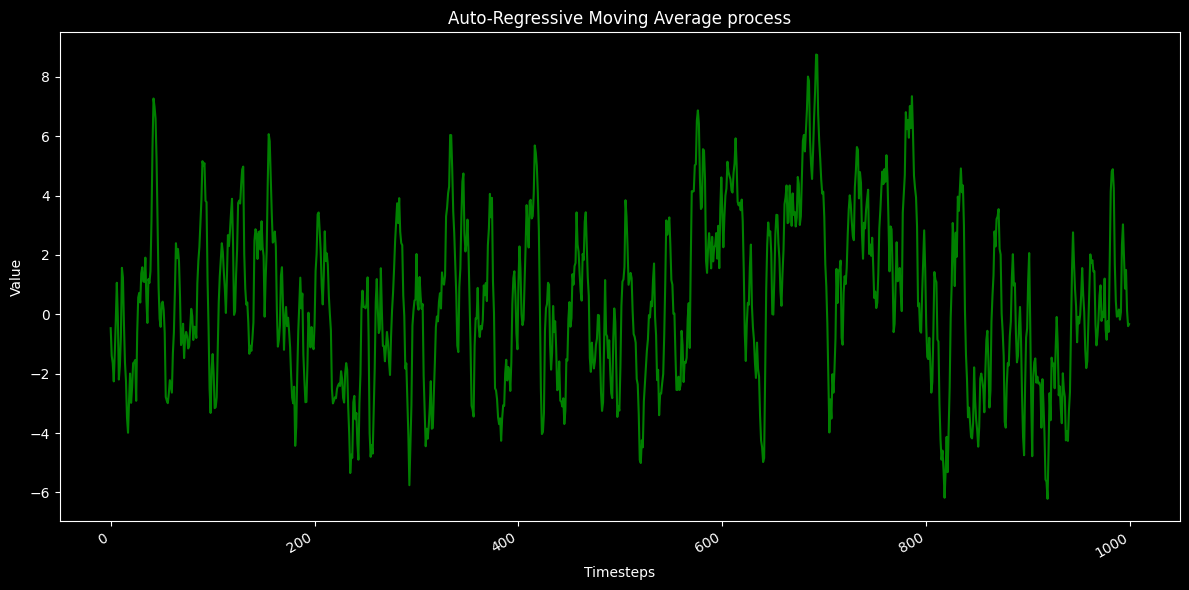

In [3]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(ARMA22_process, color='g')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Auto-Regressive Moving Average process')
fig.autofmt_xdate()
plt.tight_layout()

## Par 2. Test stationary

To test stationary, Augmented Dickey-Fuller test will be used.

In [4]:
ADF_result = adfuller(ARMA22_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.24494515491655
p-value: 1.842660564614094e-10


Here, the p-value is much less than a significance of 0.05, hence our time series is stationary.

## Par 3. Candidates to approximate our model

Here we are going to get the different pair-combinantions for $p,q=0,1,2,3,$ and generate the models.

In [5]:
p = range(0, 4, 1)
q = range(0, 4, 1)

order_list = list(product(p, q)) # generating the pairs of (p,q)

## Part 4. Getting the best candidate

Here, we wil use SARIMAX from statsmodels to fit every combination of $(p,q)$, to the results the *Akaike Iformation Criterio (AIC)* will be applied to get the best candidate.

In [6]:

def fit_AIC_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    """
    This function creates a SARIMAX model for each pair (p,q) and fit the data. After that, }
    it gets the AIC score for the model and save the results in a dataframe ordered by the 
    AIC ascending.

    Parameters:
        endog (pd.Series or list): data train.
        order_list (list): list of pairs/candidates (p,q).

    Return:
        two columns-pd.DataFrame with the pair (p,q) and their respective AIC score.

    """
    results = []
    
    for pair in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(pair[0], 0, pair[1]), simple_differencing=False).fit(disp=False) # fitting thje data
        except:
            continue
            
        aic = model.aic # get the AIC score
        results.append([pair, aic]) # save the results
        

    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC'])
    
    # sort by AIC
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [7]:
result_df = fit_AIC_ARMA(train, order_list)
result_df

100%|██████████| 16/16 [00:00<00:00, 16.46it/s]


,"(p,q)",AIC
0,"(2, 2)",2253.313442
1,"(3, 2)",2255.234230
2,"(2, 3)",2255.275519
3,"(3, 3)",2256.522635
4,"(3, 1)",2259.777485
5,"(1, 2)",2262.285080
6,"(2, 0)",2262.586969
7,"(1, 3)",2263.690576
8,"(3, 0)",2264.586289
9,"(2, 1)",2264.586441


As expected, the model with $(p,q) = (2,2)$ produced the best results. So, let's use this combination to apply a residual analysis.

## Part 5. Redisual Analysis

The pair $(2,2)$ produced the lowest AIC score. Let's apply a Residual analysis: qualitative and quantitative. For the qualitative analysis we will generate a $Q-Q$ plot and for quantitative, we will apply a LJung-Box test.

> ###  Qualitative analysis

In [8]:
model = SARIMAX(train, order=(2,0,2), simple_differencing=False) # winner candidate
model_fit = model.fit(disp=False) # fitting the model

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1121.657
Date:                Fri, 17 Mar 2023   AIC                           2253.313
Time:                        13:31:00   BIC                           2276.737
Sample:                             0   HQIC                          2262.312
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1172      0.087      1.344      0.179      -0.054       0.288
ar.L2          0.6696      0.082      8.155      0.000       0.509       0.831
ma.L1          1.1337      0.087     13.011      0.0

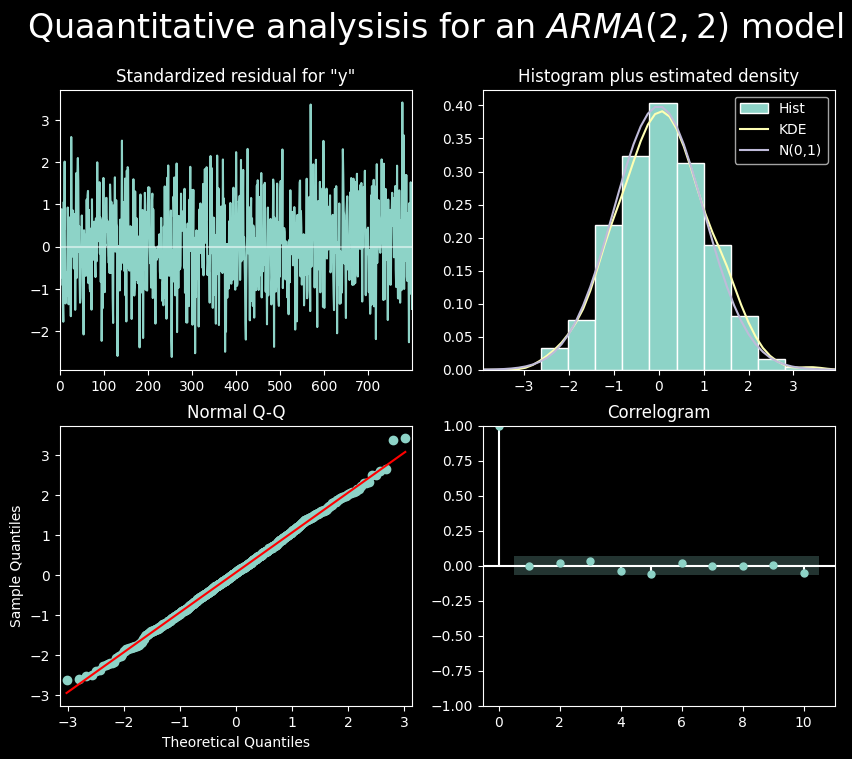

In [9]:
plot = model_fit.plot_diagnostics(figsize=(10, 8))

plot.suptitle('Quaantitative analysisis for an $ARMA(2,2)$ model\n', size=24)
plot.subplots_adjust(top=0.88)

As it can be seen: 
- In the top-left plot there is no trend in the data (mean constant over time and residuals are likely stationary).
- The top-right shows the density plot (approximately a Normal distribution).
- The $Q-Q$ plot at the bottom left, most opf the quantiles behaive as linear trend $y=x$.
- Finally, the ACF plot shows there is no autocorrelation after lag 0.

Therefore, our model has passed the Quantitative anlysis succesfully.

> ###  Quantitative analysis
Here we will use LJung-Box test to the first 10 lags. 

In [10]:
residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))



,lb_stat,lb_pvalue
1,0.000122,0.991176
2,0.371360,0.830539
3,1.161998,0.762132
4,2.230109,0.693521
5,5.142922,0.398688
6,5.480811,0.483779
7,5.490502,0.600330
8,5.504531,0.702538
9,5.508198,0.787951
10,7.951965,0.633529


All the p-values are greater that a significance of 0.05, rejecting the null-hypothesis. This is a good result, due to the null-hypothesis in the LJung-Box test states that the data is independenly distribuited, meaning that there is no autocorrelation.
Therefore, our model has passed  the Quantitative analysis too.

So, an $ARMA(2,2)$ is the winner.

## Part 6. Forecasting
The ARMA(2,2) model was the winner, so let's use this one in order to forecast using the ***Rolling Forecasting method*** with SARIMAX.

In [11]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    """
    This function applys the rolling forecast method using SARIMAX in time series, ie,
    the model is train with the train data, then it is used to forecast the next n(window) steps. 
    After that, the model is trained again with the new data to forecast the next n(window) steps,
    and so on, until all the horizon steps have been forecasted.
    
    Parameters:
        df (pd.DataFrame): dataframe with the data.
        train_len (int): lenght of the train data.
        test_len (int): lenght of the test data.
        horizon (int): number of total steps to forecast.
        window (int): nuumber of steps to forecast in each iteration.
    
    Return:
        pred_ARMA (list): list with all the predictions.
    """
    total_len = train_len + horizon

    pred_ARMA = []

    for i in tqdm(range(train_len, total_len, window)):
        model = SARIMAX(df[:i], order=(0,0,2))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARMA.extend(oos_pred)
    
    return pd.DataFrame(pred_ARMA, columns=['pred_ARMA(2,2)']).reset_index(drop=True)

In [12]:
# Traingn and testing
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_ARMA2  = rolling_forecast(pd.DataFrame(ARMA22_process), TRAIN_LEN, HORIZON, WINDOW)

test = pd.concat([pd.DataFrame(test).reset_index(drop=True), pred_ARMA2], axis=1)
test.reset_index(drop=True, inplace=True)
test.index = test.index + 800

test.head()

100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


,0,"pred_ARMA(2,2)"
800,-0.361663,0.196912
801,-1.434518,-0.596747
802,-1.510669,-0.552761
803,-0.790952,-0.100931
804,-1.619326,-0.030344


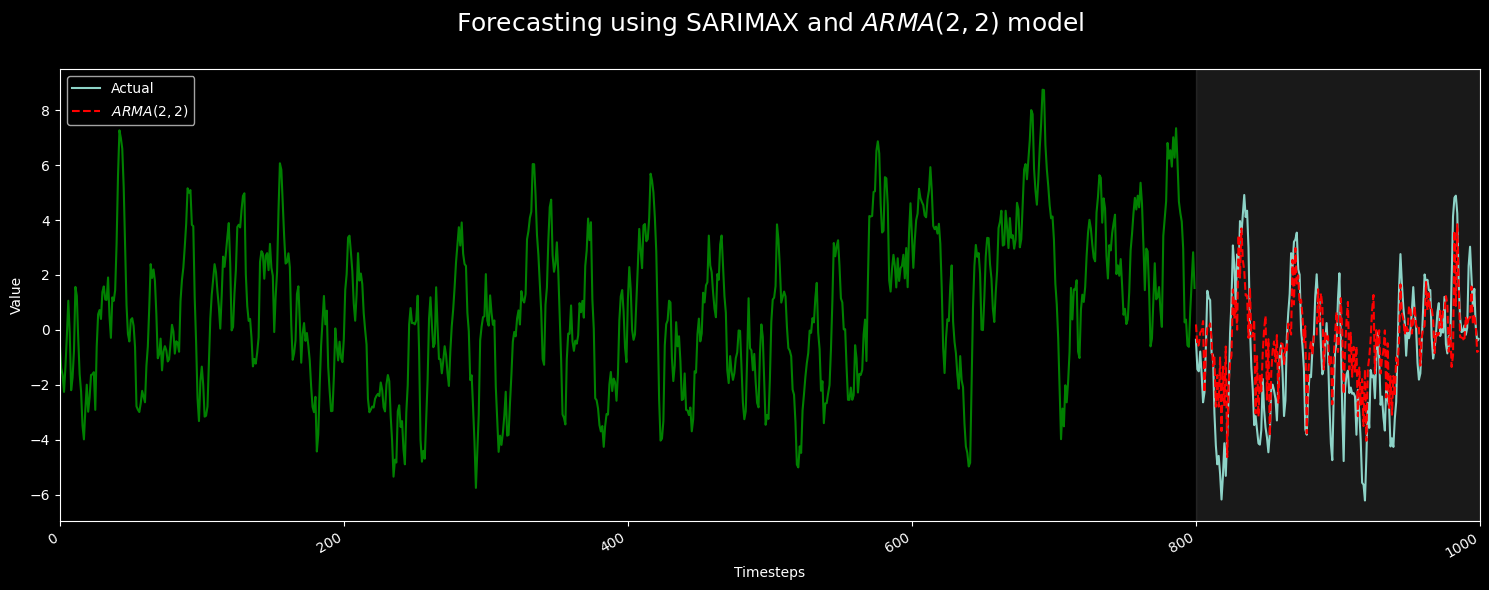

In [13]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train, color='g')
ax.plot(test[0], label='Actual',)
ax.plot(test['pred_ARMA(2,2)'], 'k--', label='$ARMA(2,2)$', color='r')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_title('Forecasting using SARIMAX and $ARMA(2,2)$ model\n', size=18)
plt.xlim(0, 1000)
fig.autofmt_xdate()
plt.tight_layout()

### Testing our forecasting

In [14]:
# test using MSE
mse_ARMA = mean_squared_error(test[0], test['pred_ARMA(2,2)'])
mse_ARMA

3.1759570431274096

In [15]:
# test using MSE
mae_ARMA = mean_absolute_error(test[0], test['pred_ARMA(2,2)'])
mae_ARMA

1.4009466815629223

The error is too low, so that our model was a good perfomance.